In [16]:
import numpy as np

from preprocessing import BCIDataProcessor

In [17]:
recording_path = '../recordings/recording_ssvep4_gel.raw.fif'
window_size = 2
window_overlap = 1
nfft1 = 500
nfft2 = 500
processor = BCIDataProcessor(recording_path, l_freq=7, h_freq=30, window_size=window_size,
                             window_overlap=window_overlap)
processor1 = BCIDataProcessor(recording_path, l_freq=10, h_freq=12, window_size=window_size,
                              window_overlap=window_overlap)
processor2 = BCIDataProcessor(recording_path, l_freq=14, h_freq=16, window_size=window_size,
                              window_overlap=window_overlap)
processor3 = BCIDataProcessor(recording_path, l_freq=18, h_freq=20, window_size=window_size,
                              window_overlap=window_overlap)
processor4 = BCIDataProcessor(recording_path, l_freq=22, h_freq=24, window_size=window_size,
                              window_overlap=window_overlap)
processor5 = BCIDataProcessor(recording_path, l_freq=19, h_freq=21, window_size=window_size,
                              window_overlap=window_overlap)
data_arrays = processor.process(psds=True, nfft=nfft1, channels=(5, 6, 7))
data_arrays1 = processor1.process(psds=True, nfft=nfft2, channels=(5, 6, 7))
data_arrays2 = processor2.process(psds=True, nfft=nfft2, channels=(5, 6, 7))
data_arrays3 = processor3.process(psds=True, nfft=nfft2, channels=(5, 6, 7))
data_arrays4 = processor4.process(psds=True, nfft=nfft2, channels=(5, 6, 7))
data_arrays5 = processor5.process(psds=True, nfft=nfft2, channels=(5, 6, 7))
arr_all = [
    #data_arrays,
    data_arrays1,
    data_arrays2,
    data_arrays3,
    data_arrays4,
    data_arrays5
]

In [18]:
# Merge data arrays along feature axis
feature_arrays = {}
for label in data_arrays.keys():
    feature_arrays[label] = np.concatenate([arr[label] for arr in arr_all], axis=2)
feature_arrays['15.0'].shape  # (samples, channels, features)

(45, 3, 25)

In [19]:
# Create X and y based on the labels
X = np.concatenate(list(feature_arrays.values()), axis=0)  # (samples, channels, features)
y = np.concatenate([[label] * feature_arrays[label].shape[0] for label in feature_arrays.keys()])  # (samples,)
# Reshape X to 2D (samples, features)
X = X.reshape(X.shape[0], -1)  # (samples, channels * features)
# Check the shape of X and y
print("X shape:", X.shape)  # (samples, channels * features)

X shape: (180, 75)


Nested CV Accuracy Scores: [0.5862069  0.79310345 0.62068966 0.55172414 0.53571429]
Mean Nested CV Accuracy: 0.617487684729064

Best Parameters After Full Training: {'svc__C': 0.01, 'svc__gamma': 'scale', 'svc__kernel': 'linear'}

Classification Report on Holdout Test Set:
               precision    recall  f1-score   support

        11.0       0.67      0.89      0.76         9
        15.0       0.67      0.67      0.67         9
        19.0       0.71      0.56      0.62         9
        23.0       0.50      0.44      0.47         9

    accuracy                           0.64        36
   macro avg       0.64      0.64      0.63        36
weighted avg       0.64      0.64      0.63        36



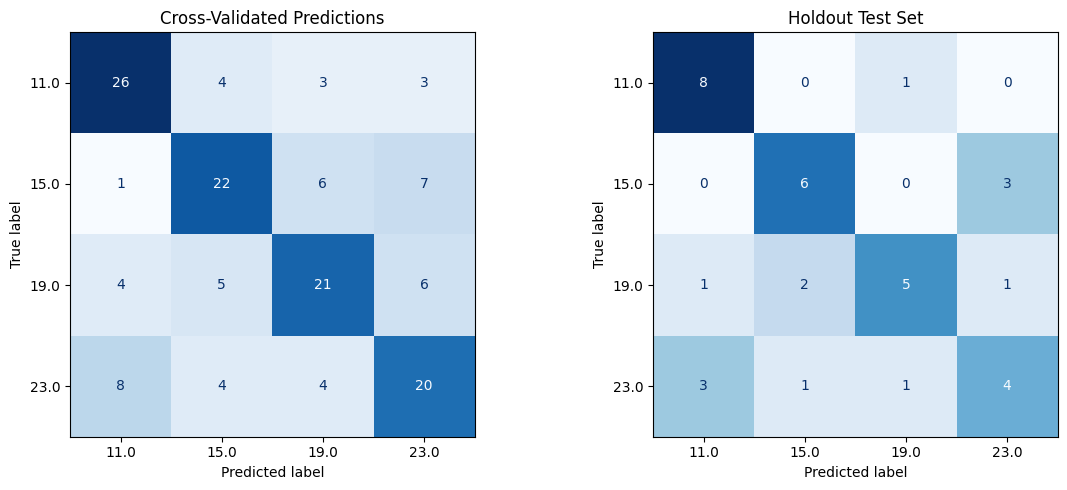

In [20]:
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_predict, cross_val_score, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Assume X and y are already defined
# Holdout split
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# It's essential to scale features for SVM
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC())
])

# Hyperparameter grid (slightly enhanced)
param_grid = {
    'svc__C': [0.01, 0.1, 1, 10],  # added C=10 for slightly stronger regularization control
    'svc__kernel': ['linear'],
    'svc__gamma': ['scale']
}

# Outer cross-validation strategy
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Inner cross-validation strategy for hyperparameter tuning
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Grid search with refit=True (default)
grid_search = GridSearchCV(pipeline, param_grid, cv=inner_cv, scoring='accuracy', n_jobs=-1, refit=True)

# Perform nested cross-validation on training+validation set
nested_scores = cross_val_score(grid_search, X_train_val, y_train_val, cv=outer_cv, scoring='accuracy', n_jobs=-1)

print("Nested CV Accuracy Scores:", nested_scores)
print("Mean Nested CV Accuracy:", np.mean(nested_scores))

# Fit GridSearchCV on full training+validation set
grid_search.fit(X_train_val, y_train_val)
best_model = grid_search.best_estimator_
print("\nBest Parameters After Full Training:", grid_search.best_params_)

# Cross-validated predictions on training+validation set
y_train_val_pred = cross_val_predict(best_model, X_train_val, y_train_val, cv=outer_cv)

# Confusion matrix for cross-validated predictions (not normalized)
cm_cv = confusion_matrix(y_train_val, y_train_val_pred)
class_labels = np.unique(y)

# Evaluate on holdout test set
y_test_pred = best_model.predict(X_test)

print("\nClassification Report on Holdout Test Set:\n", classification_report(y_test, y_test_pred))

# Confusion matrix for holdout test set (not normalized)
cm_test = confusion_matrix(y_test, y_test_pred)

# Plot confusion matrices side-by-side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Cross-validated confusion matrix
disp_cv = ConfusionMatrixDisplay(confusion_matrix=cm_cv, display_labels=class_labels)
disp_cv.plot(cmap=plt.cm.Blues, ax=axes[0], colorbar=False)
axes[0].set_title("Cross-Validated Predictions")

# Holdout test confusion matrix
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=class_labels)
disp_test.plot(cmap=plt.cm.Blues, ax=axes[1], colorbar=False)
axes[1].set_title("Holdout Test Set")

plt.tight_layout()
plt.show()

In [21]:
import joblib
joblib.dump(best_model, 'final_svm_model.pkl')
print("\nModel saved to 'final_svm_model.pkl'")


Model saved to 'final_svm_model.pkl'


In [22]:
import joblib

loaded_model = joblib.load('final_svm_model.pkl')

# Predict on full dataset
y_pred_full = loaded_model.predict(X[0:10, :])
y_pred_full

array(['19.0', '15.0', '15.0', '15.0', '15.0', '15.0', '23.0', '15.0',
       '15.0', '15.0'], dtype='<U4')